### importok

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [2]:
with open('model_ready_dict.pickle', 'rb') as handle:
    model_ready_dict = pickle.load(handle)

In [3]:
big5 = pd.concat(model_ready_dict.values(), ignore_index=True)

In [4]:
for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

### leiro statok

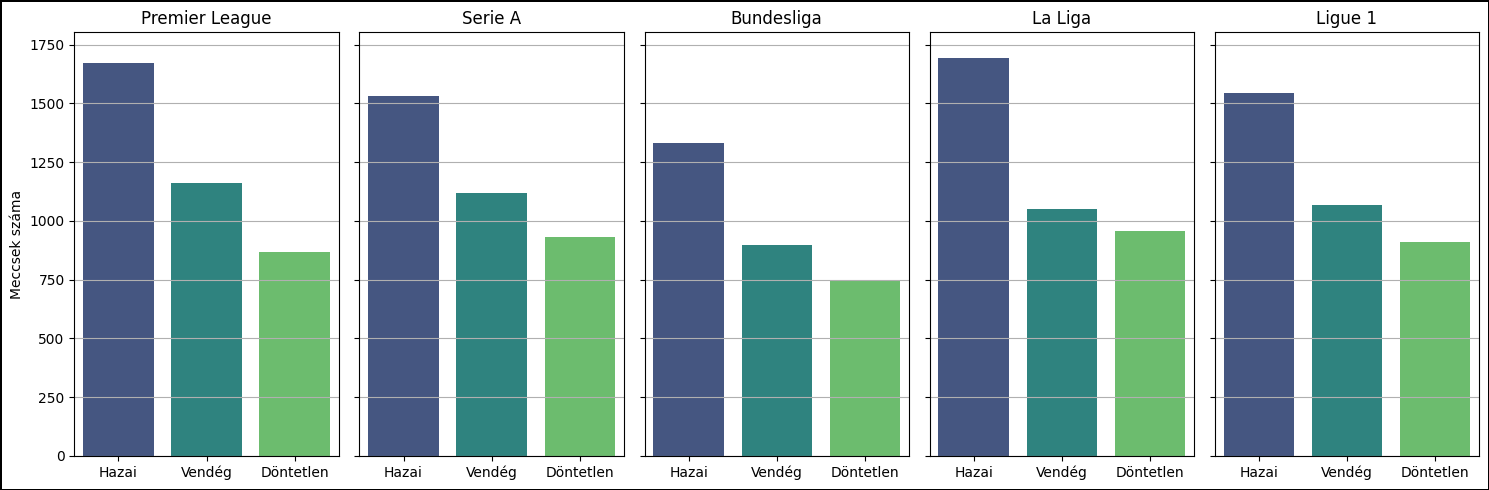

In [35]:
num_leagues = len(model_ready_dict)

fig, axes = plt.subplots(1, num_leagues, figsize=(3 * num_leagues, 5), sharey=True)
fig.patch.set_edgecolor('black')  
fig.patch.set_linewidth(2) 

for ax, (league_name, df) in zip(axes, model_ready_dict.items()):
    outcome_counts = {
        'FTR': ['Hazai', 'Vendég', 'Döntetlen'],
        'db': [
            df['target_home_win'].sum(),
            df['target_away_win'].sum(),
            df['target_draw'].sum() ]
    }

    outcomes_df = pd.DataFrame(outcome_counts)

    sns.barplot(data=outcomes_df, x='FTR', y='db', hue='FTR', palette='viridis', ax=ax, legend=False)
    
    ax.set_title(f'{league_name.split("_")[0]}')
    ax.set_ylabel('Meccsek száma')

    max_count = max(max(df['target_home_win'].sum(),
                        df['target_away_win'].sum(),
                        df['target_draw'].sum())
                    for df in model_ready_dict.values())
    ax.set_ylim(0, max_count+110)
    
    ax.grid(axis='y')
    
    for ax in axes:
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig(r'abrak/FTR_3way.jpg', format='jpg', dpi=300)  
plt.show()

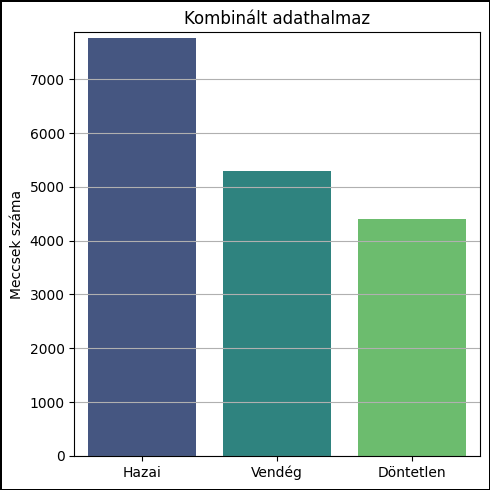

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))  # Only one subplot for 'big5'
fig.patch.set_edgecolor('black')  
fig.patch.set_linewidth(2) 

outcome_counts = {
    'FTR': ['Hazai', 'Vendég', 'Döntetlen'],
    'db': [
        big5['target_home_win'].sum(),
        big5['target_away_win'].sum(),
        big5['target_draw'].sum() ]
}

outcomes_df = pd.DataFrame(outcome_counts)

sns.barplot(data=outcomes_df, x='FTR', y='db', hue='FTR', palette='viridis', ax=ax, legend=False)

ax.set_title('Kombinált adathalmaz')
ax.set_ylabel('Meccsek száma')

max_count = max(big5['target_home_win'].sum(),
                big5['target_away_win'].sum(),
                big5['target_draw'].sum())
ax.set_ylim(0, max_count + 110)

ax.grid(axis='y')
ax.set_xlabel('')  

plt.tight_layout()
plt.savefig(r'abrak/FTR_big5.jpg', format='jpg', dpi=300)  
plt.show()

In [46]:
outcome_counts

{'FTR': ['Hazai', 'Vendég', 'Döntetlen'],
 'db': [np.int64(7766), np.int64(5294), np.int64(4404)]}

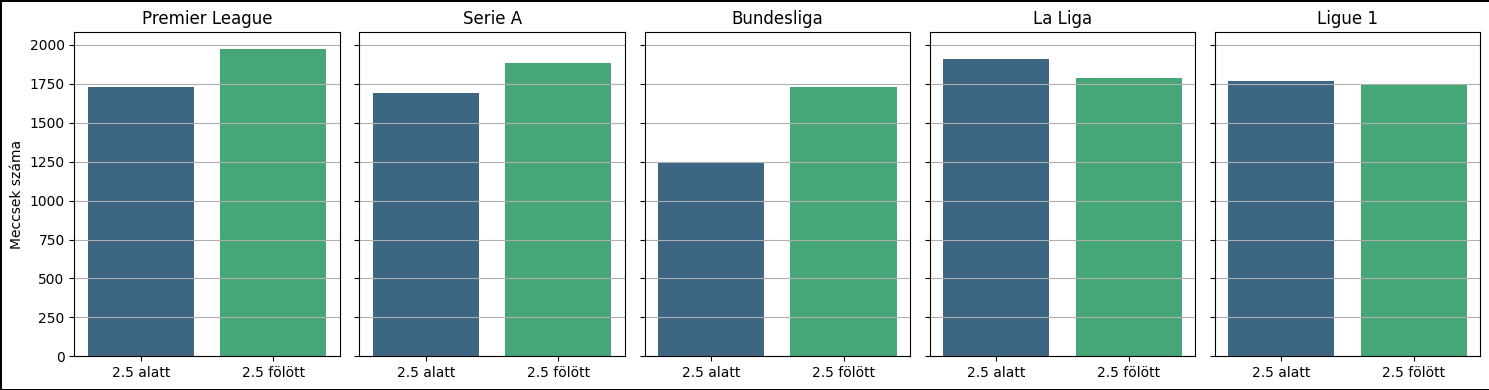

In [59]:
num_leagues = len(model_ready_dict)
fig, axes = plt.subplots(1, num_leagues, figsize=(3 * num_leagues, 4), sharey=True)
fig.patch.set_edgecolor('black')  
fig.patch.set_linewidth(2)
for ax, (league_name, df) in zip(axes, model_ready_dict.items()):
    
    valid_var_name = league_name.replace(' ', '_').replace('-', '_').replace('.', '_')
    
    exec(f"outcomes_{valid_var_name} = df['target_o2.5'].value_counts().reset_index()")
    exec(f"outcomes_{valid_var_name}.columns = ['target_o2.5', 'db']")
    exec(f"outcomes_{valid_var_name}['u/o'] = outcomes_{valid_var_name}['target_o2.5'].map({{0: '2.5 alatt', 1: '2.5 fölött'}})")
    exec(f"total_matches = outcomes_{valid_var_name}['db'].sum()")
    exec(f"outcomes_{valid_var_name}['percentage'] = (outcomes_{valid_var_name}['db'] / total_matches) * 100")
    
    outcomes_df = eval(f"outcomes_{valid_var_name}")
    
    viridis_colors = sns.color_palette('viridis', 2)
    palette = {'2.5 alatt': viridis_colors[0],  
           '2.5 fölött': viridis_colors[1]} 
    sns.barplot(data=outcomes_df, x='u/o', y='db', hue='u/o', palette=palette, 
                ax=ax, legend=False, order=['2.5 alatt', '2.5 fölött'])
    
    ax.set_title(f'{league_name.split("_")[0]}')
    ax.set_ylabel('Meccsek száma')
    
    max_count = max(df['target_o2.5'].value_counts().max() for df in model_ready_dict.values())
    ax.set_ylim(0, max_count+110)
    ax.grid(axis='y')
for ax in axes:
    ax.set_xlabel('')  
plt.tight_layout()
plt.savefig(r'abrak/UnderOver_2.5.jpg', format='jpg', dpi=300)  
plt.show()

In [77]:
outcomes_Ligue_1

,target_o2.5,db,u/o,percentage
0,0,1771,2.5 alatt,50.298211
1,1,1750,2.5 fölött,49.701789


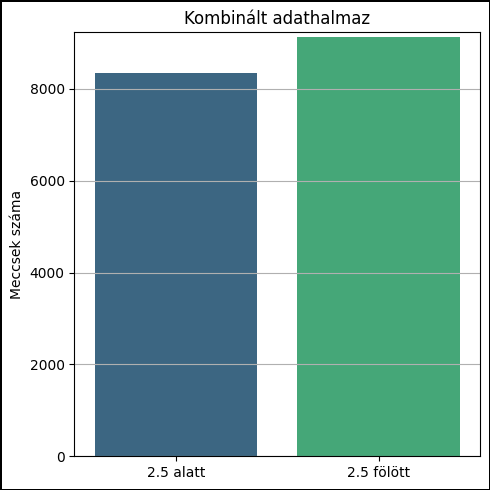

In [66]:
fig, ax = plt.subplots(figsize=(5, 5))  
fig.patch.set_edgecolor('black')  
fig.patch.set_linewidth(2)

outcomes_df = big5['target_o2.5'].value_counts().reset_index()
outcomes_df.columns = ['target_o2.5', 'db']
outcomes_df['u/o'] = outcomes_df['target_o2.5'].map({0: '2.5 alatt', 1: '2.5 fölött'})

viridis_colors = sns.color_palette('viridis', 2)
palette = {'2.5 alatt': viridis_colors[0], 
           '2.5 fölött': viridis_colors[1]}  

sns.barplot(data=outcomes_df, x='u/o', y='db', hue='u/o', palette=palette, 
            ax=ax, legend=False, order=['2.5 alatt', '2.5 fölött'])

ax.set_title('Kombinált adathalmaz')
ax.set_ylabel('Meccsek száma')

max_count = outcomes_df['db'].max()
ax.set_ylim(0, max_count + 110)

ax.grid(axis='y')

ax.set_xlabel('')

plt.tight_layout()
plt.savefig(r'abrak/UnderOver_2.5_big5.jpg', format='jpg', dpi=300)  
plt.show()

In [72]:
outcomes_df['ratio'] = outcomes_df[outcomes_df

,target_o2.5,db,u/o,ratio
0,1,9120,2.5 fölött,False
1,0,8344,2.5 alatt,False


### odds

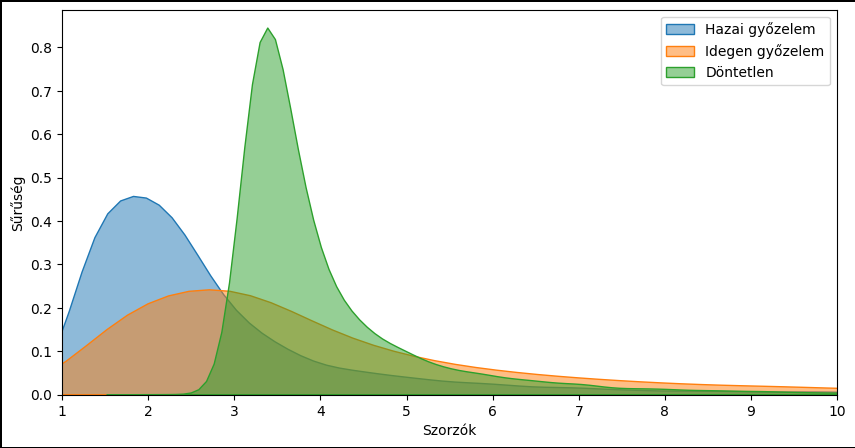

In [124]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_edgecolor('black')  
fig.patch.set_linewidth(2)

sns.kdeplot(big5['HomeW_odds_market'], label='Hazai győzelem', fill=True, alpha=0.5)
sns.kdeplot(big5['AwayW_odds_market'], label='Idegen győzelem', fill=True, alpha=0.5)
sns.kdeplot(big5['Draw_odds_market'], label='Döntetlen', fill=True, alpha=0.5)

plt.xlim(1, 10)
plt.xlabel("Szorzók")
plt.ylabel("Sűrűség")

plt.legend()
plt.savefig(r'abrak/FTR_surusegfgv_big5.jpg', format='jpg', dpi=300)  
plt.show()

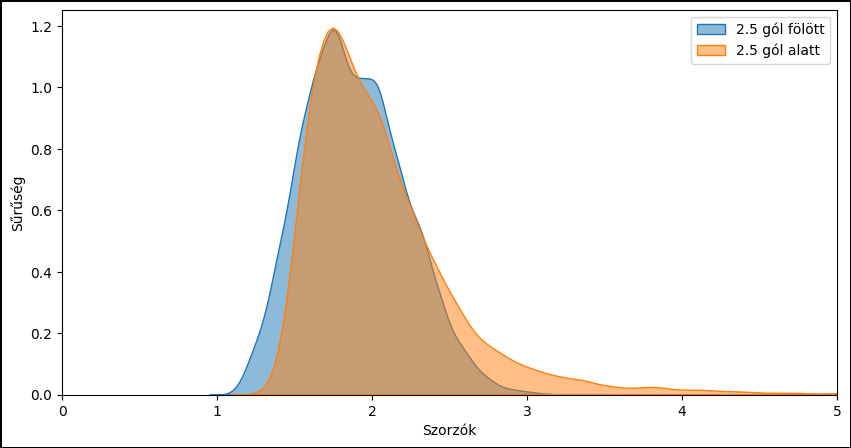

In [119]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_edgecolor('black')  
fig.patch.set_linewidth(2)

sns.kdeplot(big5['O2.5_odds_market'], label='2.5 gól fölött', fill=True, alpha=0.5)
sns.kdeplot(big5['U2.5_odds_market'], label='2.5 gól alatt', fill=True, alpha=0.5)

plt.xlim(0, 5)
plt.xlabel("Szorzók")
plt.ylabel("Sűrűség")

plt.legend()
plt.savefig(r'abrak/UnderOver_surusegfgv_big5.jpg', format='jpg', dpi=300)  
plt.show()